# Working with NEMO files

Here are some examples for plotting outputs on a NEMO grid. 

## Building variable

Let's first build a bathymetric field using the vertical scale factors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.feature as cfeature
import cartopy.crs as ccrs

data = xr.open_dataset('data/mesh_mask_eORCA1_v2.2.nc')
data = data.isel(t=0)
tmask = data['tmask'].values
e3t = data['e3t_0'].values
lon = data['glamt'].values
lat = data['gphit'].values

bathy = np.sum(e3t * tmask, axis=0)
bathy = np.ma.masked_where(bathy == 0, bathy)

## First try

If we first try to use the `pcolormesh` as we learned, here is what comes out:

/home/barrier/Softwares/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


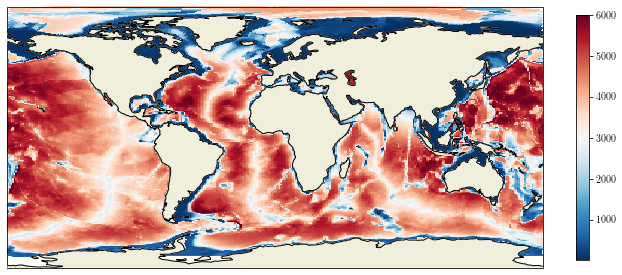

In [2]:
fig = plt.figure(figsize=(12, 15))
ax = plt.axes(projection=ccrs.PlateCarree())
cs = ax.pcolormesh(lon, lat, bathy, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=50)
ax.add_feature(cfeature.COASTLINE, zorder=51)
cb = plt.colorbar(cs, shrink=0.3)

We have an error message saying that the longitudes and latitudes are not monotonic. Let's improve our figure.

##  Better way

As indicated in [the documentation](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.pcolormesh.html), the `pcolormesh` method assumes the following layout:

```
(X[i+1, j], Y[i+1, j])          (X[i+1, j+1], Y[i+1, j+1])
                      +--------+
                      | C[i,j] |
                      +--------+
    (X[i, j], Y[i, j])          (X[i, j+1], Y[i, j+1])
```

Therefore, the good way to draw is to provide the coordinates of the `F` points (upper-right corners), and to give a sub-array of `T` points.

**Grid layout of NEMO outputs:**

<img src="figs/nemo-index.png" width="30%">

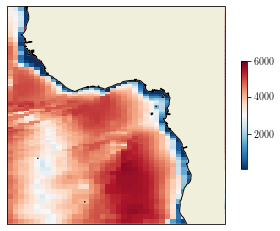

In [3]:
lonf = data['glamf'].data
latf = data['gphif'].data
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
cs = ax.pcolormesh(lonf, latf, bathy[1:, 1:], transform=ccrs.PlateCarree(), shading='flat')
ax.set_extent([-20, 20, -20, 20], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, zorder=2)
ax.add_feature(cfeature.LAND, zorder=1)
cb = plt.colorbar(cs, shrink=0.5)

## Contour plots

However, the  drawing of contour plots is not simple on irregular grid. Instead, we need to use the
`tricontour` method, as indicated [here](https://matplotlib.org/stable/gallery/images_contours_and_fields/irregulardatagrid.html). 

First, we recover the coordinates on the `T` points, not on the `F` points as for `pcolormesh`.

In [4]:
lont = data['glamt'].data
latt = data['gphit'].data

Then, we extract the data mask.

In [5]:
mask = (np.ma.getmaskarray(bathy))

Now, we extract the bathy, longitudes and latitudes on wet points and we convert into 1D arrays:

In [6]:
lon1d = np.ravel(lont[~mask])
lat1d = np.ravel(latt[~mask])
bat1d = np.ravel(bathy[~mask])
bat1d

masked_array(data=[121.15876481013115, 64.95892756174798,
                   515.0322590608843, ..., 24.57716311091656,
                   24.57716311091656, 24.57716311091656],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

The next step is to convert our 1D geographical coordinates (lon/lat) into the coordinates of the output map. If we want to draw our contours on a Mollweide projection:

In [7]:
projin = ccrs.PlateCarree()
projout = ccrs.Mollweide(central_longitude=180)
#projout = ccrs.PlateCarree(central_longitude=0)

output = projout.transform_points(projin, lon1d, lat1d)
lonout = output[..., 0]
latout = output[..., 1]
latout.shape

(65549,)

Now, we can add contours using the `tricontour` method:

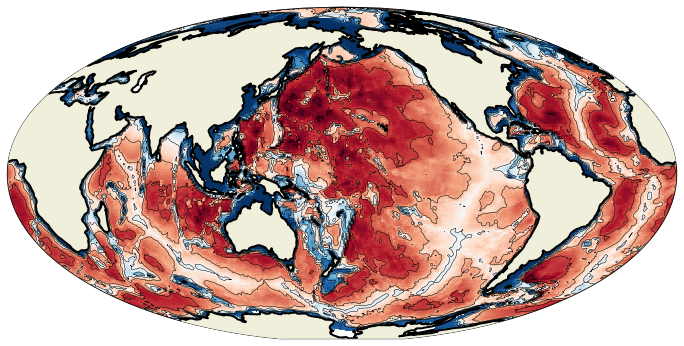

In [8]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=projout)
cs = ax.pcolormesh(lonf, latf, bathy[1:, 1:], transform=projin)
cl = ax.tricontour(lonout, latout, bat1d, levels=np.arange(0, 6000 + 1000, 1000), colors='k', linewidths=0.5)
ax.add_feature(cfeature.LAND, zorder=100)
l = ax.add_feature(cfeature.COASTLINE, zorder=101, linewidth=2)